In [1]:
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import IBMQFactory
from qiskit.circuit.exceptions import CircuitError
from qiskit.compiler import transpile
from multiprocessing import Pool
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.extensions import *
from qiskit.extensions.unitary import UnitaryGate
from scipy.linalg import schur
from qiskit import *
from qiskit.extensions import *
import numpy as np

from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.quantum_info import *
from typing import List
import os

from matplotlib import pyplot as plt
%matplotlib inline 
os.chdir('..')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv1D, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.models import Model
from preproccessing_utils import circuit_to_tensor_with_u_gates, GateEnumerator, generate_concatenated_dataset
from typing import Tuple

In [9]:
dataset = np.load("circuit_tensor_dataset.npy")
target = np.load("circuit_tensor_dataset_y.npy")
target = target.astype(np.float32)

In [44]:
concat_dataset, y_diff = generate_concatenated_dataset(dataset, target)

In [63]:
X = concat_dataset.reshape((concat_dataset.shape[0] * concat_dataset.shape[1],) + concat_dataset.shape[2:])
y = y_diff.reshape((y_diff.shape[0] * y_diff.shape[1]))
X_norm = tf.keras.utils.normalize(X)

In [41]:
def simple_convnet2d(tensor_size, num_gates, num_channels):
    inputs = Input(shape=(tensor_size, num_gates, num_channels))
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=2, strides=(2,2))(conv1)
    conv2 = Conv2D(16, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=2, strides=(2,2))(conv2)

    dense_in = Flatten()(pool2)
    drop_in = Dropout(0.25)(dense_in)
    dense1 = Dense(10, activation='relu')(drop_in)
    dense3 = Dense(1)(dense1)

    model = Model(inputs=[inputs], outputs=[dense3])
    return model

In [50]:
model = simple_convnet2d(concat_dataset.shape[2], concat_dataset.shape[3], concat_dataset.shape[4])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [51]:
history = model.fit(X_norm, y, epochs=50, batch_size=128)

Epoch 1/50
125/125 [==============================] - 4s 28ms/step - loss: 0.0094 - mean_absolute_error: 0.0699
Epoch 2/50
125/125 [==============================] - 4s 32ms/step - loss: 0.0052 - mean_absolute_error: 0.0518
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 0.0046 - mean_absolute_error: 0.0487
Epoch 4/50
125/125 [==============================] - 4s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0450
Epoch 5/50
125/125 [==============================] - 5s 37ms/step - loss: 0.0037 - mean_absolute_error: 0.0442
Epoch 6/50
125/125 [==============================] - 5s 38ms/step - loss: 0.0033 - mean_absolute_error: 0.0419
Epoch 7/50
125/125 [==============================] - 4s 33ms/step - loss: 0.0029 - mean_absolute_error: 0.0395
Epoch 8/50
125/125 [==============================] - 5s 38ms/step - loss: 0.0027 - mean_absolute_error: 0.0384
Epoch 9/50
125/125 [==============================] - 4s 33ms/step - loss: 0.0025 - mean_absolute_error:

In [64]:
y_pred = model.predict(X_norm)

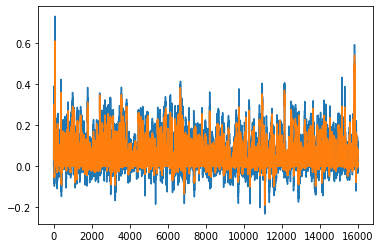

In [56]:
plt.plot(y)
plt.plot(y_pred)

In [30]:
# loss: 0.0014 - mean_absolute_error: 0.0273
# loss = MSE, optm = Adam, lr= 0.001, dropout = .1, no batch norm

In [65]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
r2_score(y, y_pred)

0.8622020831583275

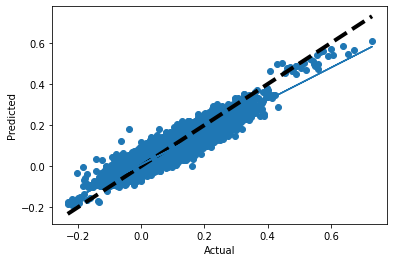

In [66]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line

y_test, y_predicted = y.reshape(-1,1), y_pred.reshape(-1,1)
ax.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test))
plt.show()

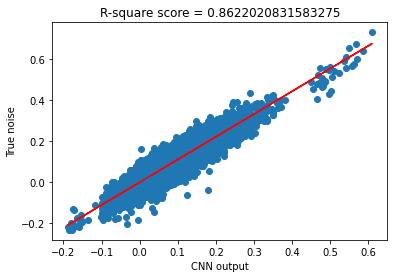

In [86]:
linreg = LinearRegression(fit_intercept=False)
obj = linreg.fit(y_pred, y)
trend_line = linreg.predict(y_pred)
plt.scatter(y_pred, y)
plt.plot(y_pred, trend_line, color='red')
plt.xlabel('CNN output')
plt.ylabel('True noise')
plt.title('R-square score = {}'.format(r2_score(y, y_pred)))
plt.show()
# y_pred explains 0.86% of the variance

In [210]:
# get the maximum difference in noise from each of the predictions
# if the noise of c0 is n(c_o), we want to maximize noise n(c_0) - n(ci).
# if n(ci) < n(c0) then n(c_0) - n(ci) > 0
y_hat = y_pred.reshape(y_diff.shape)
y_max_difference = np.argmax(y_hat, axis=1)

In [115]:
y_true = y.reshape(y_diff.shape)

In [216]:
# Ignore this step 
# best_circuits = y_true[np.arange(y_true.shape[0]), y_max_difference]

In [217]:
# We index the true variables with the 
# best circuit indices attained from y_pred
best_noise = target[np.arange(target.shape[0]), y_max_difference]

In [213]:
# The unmodified transpiller circuit is always at index 0
qasm_noise = target[np.arange(target.shape[0]), np.zeros(target.shape[0]).astype(np.int)]

In [214]:
# Average percentage of noice mitigated 
100 - ((np.mean(best_noise) / np.mean(qasm_noise)) * 100)

8.114749193191528

In [215]:
# Average noise
np.mean(best_noise), np.mean(qasm_noise)

(0.9061358, 0.9861602)